In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data pre-processing borrowed from 
https://deepimaging.github.io/past_projects/Spring_2020/yl642_cs557_sl597_BME590L/website_template/project_template.html

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# import csv

# filename = '/content/drive/My Drive/HAM10000/HAM10000_metadata.csv'
# try:
#   trial = open(filename, 'r')
# except IOError:
#   print('There was an error reading the file!')

# content = []

# with open(filename, 'r') as csv_file:
#   csv_reader = csv.reader(csv_file)
#   for line in csv_reader:
#     content.append(line)
# print(len(content))
# print(content[0])
# print(content[1])
# del line, csv_file

In [ ]:
# labels = []
# files = []
# for i in range(1, len(content)):
#   files.append("/content/drive/My Drive/HAM10000/HAM10000_images/" + content[i][1] + ".jpg")
#   labels.append(content[i][2])


# # print(len(files), files[1])
# print(len(labels), labels[1])

In [ ]:
# types = {'bkl': 0, 'akiec': 1, 'bcc': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
# for i in range(len(labels)):
#   for key in types.keys():
#     if key == labels[i]:
#       labels[i] = types[key]

In [ ]:
# from tqdm import tqdm
# from PIL import Image
# x_data = []
# y_data = labels
# for index,file in enumerate(tqdm(files)):
#     image = Image.open(file).resize([128,128])
#     x_data.append(np.array(image).astype(np.float32))

In [ ]:
# import pickle
# filename = '/content/drive/My Drive/HAM10000_images_resized.pickle'
# with open(filename, "wb") as f:
#   pickle.dump(x_data, f)

In [ ]:
# import pickle
# filename = '/content/drive/My Drive/HAM10000_images_resized_labels.pickle'
# with open(filename, "wb") as f:
#   pickle.dump(labels, f)

In [ ]:
x_data = []
y_data = []
import pickle
filename = '/content/drive/My Drive/HAM10000_images_resized.pickle'
filename_labels = '/content/drive/My Drive/HAM10000_images_resized_labels.pickle'
with open(filename, "rb") as f:
  x_data = np.array(pickle.load(f))
del f
with open(filename_labels, "rb") as f:
  y_data = np.array(pickle.load(f))
del f
# print(x_data.shape)
# print(y_data.shape)
# plt.imshow(x_data[4]/255.0)
# plt.title(y_data[4])

In [ ]:
len(x_data)

10015

Training: (7210, 128, 128, 3) (7210, 7)
Validation: (1803, 128, 128, 3) (1803, 7)
Test: (1002, 128, 128, 3) (1002, 7)
(128, 128, 3)


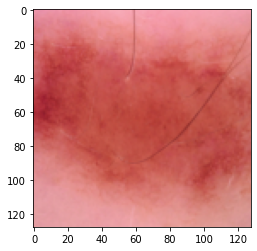

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
types = {'bkl': 0, 'akiec': 1, 'bcc': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
x_t, x_test, y_t, y_test = train_test_split(x_data, y_data, train_size = 0.9,stratify=y_data)

y_test = np.eye(len(types))[y_test]

x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, train_size = 0.8,stratify=y_t)
y_train = np.eye(len(types))[y_train]
y_val = np.eye(len(types))[y_val]


x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0


print("Training:",x_train.shape, y_train.shape)
print("Validation:",x_val.shape, y_val.shape)
print("Test:",x_test.shape, y_test.shape)

plt.imshow(x_train[0])
print(x_train[0].shape)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

x_train = x_train.reshape(x_train.shape[0], *(128, 128, 3))
data_gen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True, 
        vertical_flip=True)
data_gen.fit(x_train)

In [ ]:
from keras import regularizers
from tensorflow.python.keras.layers import Dense, Dropout
def generate_classifier():
  base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',pooling='avg', input_shape=(128,128, 3))
  model = tf.keras.Sequential()
  model.add(base_model)
  model.add(Dropout(0.5))
  model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))
  for layer in base_model.layers:
    layer.trainable = True
  return model

def train_model():
  model = generate_classifier()
  from tensorflow.keras.optimizers import Adam
  optimizer = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=5e-7, amsgrad=False)
  model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["acc"])
  epochs = 35
  history = model.fit(data_gen.flow(x_train,y_train,batch_size=64),
                              epochs = epochs, validation_data = (x_val,y_val))
  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, )
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()
  return model

Epoch 1/35
113/113 [==============================] - 31s 226ms/step - loss: 6.9831 - acc: 0.3449 - val_loss: 6.0206 - val_acc: 0.6717
Epoch 2/35
113/113 [==============================] - 25s 217ms/step - loss: 5.7000 - acc: 0.6647 - val_loss: 5.3656 - val_acc: 0.6950
Epoch 3/35
113/113 [==============================] - 24s 216ms/step - loss: 5.1426 - acc: 0.6979 - val_loss: 4.7786 - val_acc: 0.7110
Epoch 4/35
113/113 [==============================] - 24s 216ms/step - loss: 4.6482 - acc: 0.7045 - val_loss: 4.2674 - val_acc: 0.7221
Epoch 5/35
113/113 [==============================] - 24s 216ms/step - loss: 4.1547 - acc: 0.7238 - val_loss: 3.7923 - val_acc: 0.7366
Epoch 6/35
113/113 [==============================] - 24s 215ms/step - loss: 3.6950 - acc: 0.7532 - val_loss: 3.3977 - val_acc: 0.7499
Epoch 7/35
113/113 [==============================] - 24s 215ms/step - loss: 3.3199 - acc: 0.7545 - val_loss: 3.0104 - val_acc: 0.7687
Epoch 8/35
113/113 [==============================] - 2

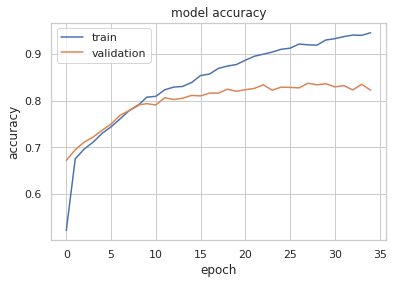

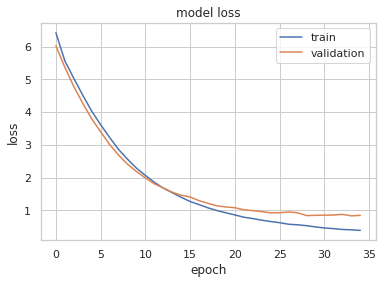

In [ ]:
#trained_model = train_model()

In [ ]:
 #trained_model.save("/content/drive/My Drive/HAM10000/HAM10000_images/trained_classifier")

INFO:tensorflow:Assets written to: /content/drive/My Drive/HAM10000/HAM10000_images/trained_classifier/assets


In [ ]:
trained_model = tf.keras.models.load_model("/content/drive/My Drive/HAM10000/HAM10000_images/trained_classifier")

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f6a08806a70>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 358, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = trained_model.evaluate(x_test, y_test, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))

32/32 [==============================] - 1s 25ms/step - loss: 0.4734 - acc: 0.9232
test_accuracy = 0.923154  ;  test_loss = 0.473367


In [ ]:
def metrics(x_test,y_test,trained_model):
  from sklearn.metrics import confusion_matrix
  data_labels = ['BKL', 'AK', 'BCC', 'DF', 'MEL', 'NEV', 'VAS']
  train_pred = trained_model.predict(x_train)
  train_pred_classes = np.argmax(train_pred,axis = 1)
  test_pred = trained_model.predict(x_test)
  # Convert predictions classes to one hot vectors 
  test_pred_classes = np.argmax(test_pred,axis = 1) 
  y_lab_c_mat = []
  for lab in y_test:
    y_lab_c_mat.append(np.argmax(lab))
  confusionmatrix = confusion_matrix(y_lab_c_mat, test_pred_classes)
  import seaborn as sns
  #mask = np.diag(np.ones(7))
  plt.figure(figsize=(10,10))
  sns.set(font_scale=1.4)
  sns.heatmap(confusionmatrix, cmap = "viridis", square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, xticklabels=data_labels, yticklabels= data_labels,fmt='g')
  from sklearn.metrics import classification_report
  # Generate a classification report
  #trainreport = classification_report(trainlabels, train_pred_classes, target_names=list(labels))
  testreport = classification_report(y_lab_c_mat, test_pred_classes, target_names=data_labels)
  #print(trainreport)
  print(testreport)

              precision    recall  f1-score   support

         BKL       0.77      0.87      0.82       110
          AK       0.88      0.70      0.78        33
         BCC       0.89      0.78      0.83        51
          DF       1.00      0.83      0.91        12
         MEL       0.83      0.84      0.83       111
         NEV       0.97      0.97      0.97       671
         VAS       1.00      0.93      0.96        14

    accuracy                           0.92      1002
   macro avg       0.91      0.85      0.87      1002
weighted avg       0.93      0.92      0.92      1002



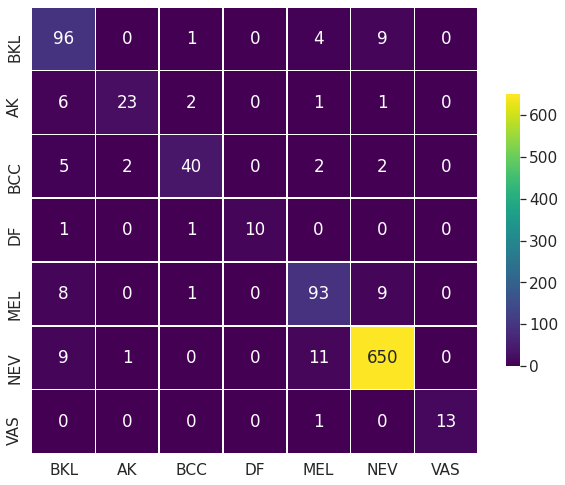

In [ ]:
metrics(x_test,y_test,trained_model)

# Image Compression Demonstration Using K-Means Clustering

128
Average Deviation for 1-bit compression: 36.05009259259259
Average Deviation for 2-bit compression: 22.03814814814815
Average Deviation for 3-bit compression: 14.004537037037037
Average Deviation for 4-bit compression: 10.113333333333333
Average Deviation for 6-bit compression: 6.009074074074074
Average Deviation for 8-bit compression: 3.957685185185185
Average Deviation for 10-bit compression: 2.531296296296296


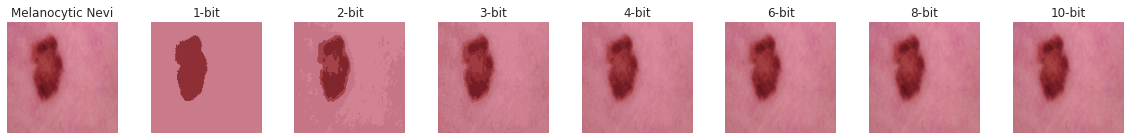

In [ ]:
# https://towardsdatascience.com/image-compression-using-k-means-clustering-aa0c91bb0eeb
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

data_labels = ['Benign keratosis-like lesion', 'Actinic keratoses', 'Basal cell carcinoma', 'Dermatofibroma', 'Melanoma', 'Melanocytic Nevi', 'Vascular lesion']
plot_titles = ["1-bit","2-bit","3-bit","4-bit","6-bit","8-bit","10-bit"]
kmeans = [2,4,8,16,64,256,2**10]

#Read the image
im_no = np.random.randint(0,len(x_train))
image = x_data[im_no]
comp = image
plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace = 0.3)
plt.subplot(181)
plt.imshow(image/255.0)
plt.axis('off')
plt.title(data_labels[y_data[im_no]])

#Dimension of the original image
rows = image.shape[0]
print(rows)
cols = image.shape[1]

#Flatten the image
image = image.reshape(rows*cols, 3)

for i,k in enumerate(kmeans):
#Implement k-means clustering to form k clusters
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(image)

#Replace each pixel value with its nearby centroid
  compressed_image = kmeans.cluster_centers_[kmeans.labels_]
  compressed_image = np.clip(compressed_image.astype('uint8'), 0, 255)

#Reshape the image to original dimension
  compressed_image = compressed_image.reshape(rows, cols, 3)

#Display output image
  plt.subplot(1,8,i+2)
  plt.imshow(compressed_image)
  plt.axis('off')
  plt.title(plot_titles[i])
  print(f"Average Deviation for {plot_titles[i]} compression: {np.sum(np.abs(np.subtract(comp,compressed_image)))/(120*90)}")
  

In [ ]:
def compressed_image(images,k):
  ret = []
  kmeans = KMeans(n_clusters=k)
  from tqdm import tqdm
  for image in tqdm(images):
    rows = 128
    cols = 128
    image = image.reshape(rows*cols, 3)
    kmeans.fit(image)
    compressed_image = kmeans.cluster_centers_[kmeans.labels_]
    compressed_image = np.clip(compressed_image.astype('uint8'), 0, 255)
    compressed_image = compressed_image.reshape(rows, cols, 3)
    ret.append(compressed_image)
  return np.array(ret)

# 1-bit compressed images

In [ ]:
data = x_test[:20]
x_test_1_bit = compressed_image(data,k=2)
metrics(x_test_1_bit,y_test,trained_model)


100%|██████████| 20/20 [00:01<00:00, 11.52it/s]


ValueError: ignored

# 2-bit Compressed Images

In [ ]:
#x_test_2_bit = compressed_image(x_test,k=4)
#metrics(x_test_2_bit,y_test)

# 3-bit Compressed Images

In [ ]:
#x_test_3_bit = compressed_image(x_test,k=8)
#metrics(x_test_3_bit,y_test)

# 4-bit Compressed Images

In [ ]:
# x_test_4_bit = compressed_image(x_test,k=16)
# metrics(x_test_4_bit,y_test)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, Dense, Reshape, Flatten
import tensorflow as tf


# def create_autoencoder(input_shape,ls_size=64):
#     input_layer = Input(input_shape)
#     x = input_layer
#     # down path
#     start_filters = 8
#     for i in range(4):
#         x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
#         x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
#         x = MaxPool2D()(x)
#     # bottleneck
#     x = Conv2D(start_filters*(2**4),3, padding='same', activation='relu')(x)
#     x = MaxPool2D()(x)
#     x = Flatten()(x)
#     x = Dense(ls_size, activation='relu')(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Reshape((4,4,64))(x)
#     x = UpSampling2D()(x)
#     x = Conv2D(start_filters*(2**4),3, padding='same', activation='relu')(x)
#     # up path
#     for i in range(4):
#         x = UpSampling2D()(x)
#         x = Conv2D(start_filters*(2**(3-i)),3, padding='same', activation='relu')(x)
#         x = Conv2D(start_filters*(2**(3-i)),3, padding='same', activation='relu')(x)
#     output = Conv2D(3, 1, activation='sigmoid')(x)
#     model = tf.keras.Model(inputs=input_layer, outputs=output)
#     return model

from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)

def create_autoencoder(input_shape,ls_size):
    input_layer = Input(input_shape)
    num_classes = 3
    x = input_layer
    # down path
    start_filters = 4
    for i in range(2):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = MaxPool2D()(x)
    # bottleneck
    x = Conv2D(start_filters*(2**ls_size),3, padding='same', activation='relu')(x)
    x = Conv2D(start_filters*(2**ls_size),3, padding='same', activation='relu')(x)
    # up path
    for i in range(2):
        x = UpSampling2D()(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
    output = Conv2D(num_classes, 1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model
    

def eval_autoencoder_performance(model, autoencoder):
  test_loss, test_acc = model.evaluate(autoencoder.predict(x_test), y_test)
  print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))
  from sklearn.metrics import confusion_matrix
  data_labels = ['BKL', 'AK', 'BCC', 'DF', 'MEL', 'NEV', 'VAS']
  train_pred = trained_model.predict(autoencoder.predict(x_train))
  train_pred_classes = np.argmax(train_pred,axis = 1)
  test_pred = trained_model.predict(autoencoder.predict(x_test))
  # Convert predictions classes to one hot vectors 
  test_pred_classes = np.argmax(test_pred,axis = 1) 
  y_lab_c_mat = []
  for lab in y_test:
    y_lab_c_mat.append(np.argmax(lab))
  confusionmatrix = confusion_matrix(y_lab_c_mat, test_pred_classes)
  import seaborn as sns
  #mask = np.diag(np.ones(7))
  plt.figure(figsize=(10,10))
  sns.set(font_scale=1.4)
  sns.heatmap(confusionmatrix, cmap = "viridis", square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, xticklabels=data_labels, yticklabels= data_labels,fmt='g')   
  from sklearn.metrics import classification_report
  # Generate a classification report
  #trainreport = classification_report(trainlabels, train_pred_classes, target_names=list(labels))
  testreport = classification_report(y_lab_c_mat, test_pred_classes, target_names=data_labels)
  #print(trainreport)
  print(testreport)


def train_autoencoder(ls_size = 3, plot = False, epochs = 10):
  autoencoder = create_autoencoder((128,128,3),ls_size)
  from tensorflow.keras.optimizers import Adam
  from tqdm import tqdm
  optimizer = Adam()
  autoencoder.compile(optimizer = optimizer , loss = 'mae')
  history = autoencoder.fit(x_train, x_train, batch_size=64, epochs = epochs, verbose = 1,validation_data = (x_val,x_val),callbacks = [reduce_lr])
  autoencoder.save(f"/content/drive/My Drive/HAM10000/HAM10000_images/autoencoder_{ls_size}")
  eval_autoencoder_performance(trained_model,autoencoder)
  if plot:
    import seaborn as sns
    sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, )
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
    plt.show()
    plt.figure()
    plt.imshow(x_train[0])
    plt.title("Image Input")
    plt.figure()
    plt.imshow(autoencoder.predict(x_train[0,np.newaxis])[0])
    plt.title("Autoencoder Reconstruction")
  return autoencoder



# 3X COMPRESSION

Epoch 1/50
113/113 [==============================] - 5s 41ms/step - loss: 0.1374 - val_loss: 0.0785
Epoch 2/50
113/113 [==============================] - 4s 40ms/step - loss: 0.0762 - val_loss: 0.0694
Epoch 3/50
113/113 [==============================] - 4s 40ms/step - loss: 0.0686 - val_loss: 0.0673
Epoch 4/50
113/113 [==============================] - 4s 40ms/step - loss: 0.0659 - val_loss: 0.0625
Epoch 5/50
113/113 [==============================] - 4s 39ms/step - loss: 0.0623 - val_loss: 0.0560
Epoch 6/50
113/113 [==============================] - 4s 39ms/step - loss: 0.0525 - val_loss: 0.0373
Epoch 7/50
113/113 [==============================] - 4s 39ms/step - loss: 0.0352 - val_loss: 0.0279
Epoch 8/50
113/113 [==============================] - 4s 39ms/step - loss: 0.0273 - val_loss: 0.0281
Epoch 9/50
113/113 [==============================] - 4s 39ms/step - loss: 0.0250 - val_loss: 0.0233
Epoch 10/50
113/113 [==============================] - 4s 39ms/step - loss: 0.0240 - val_lo

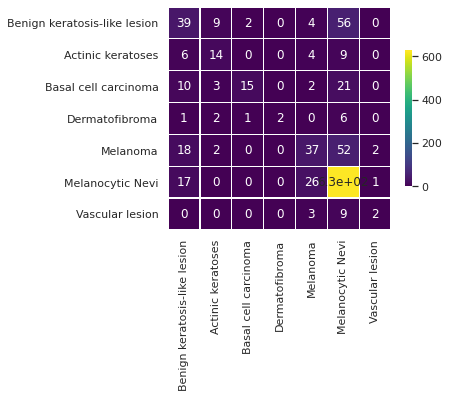

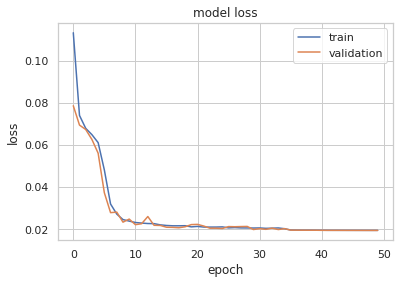

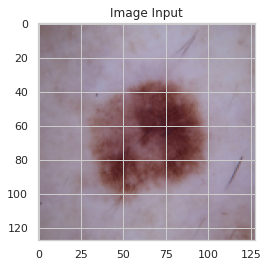

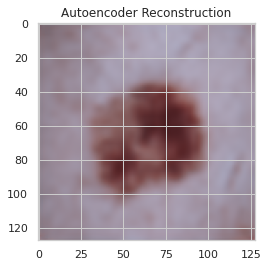

In [ ]:
train_autoencoder(ls_size = 2, plot = True, epochs = 50)

# 6X COMPRESSION

Epoch 1/50
113/113 [==============================] - 5s 40ms/step - loss: 0.1291 - val_loss: 0.0790
Epoch 2/50
113/113 [==============================] - 4s 38ms/step - loss: 0.0759 - val_loss: 0.0558
Epoch 3/50
113/113 [==============================] - 4s 38ms/step - loss: 0.0550 - val_loss: 0.0515
Epoch 4/50
113/113 [==============================] - 4s 38ms/step - loss: 0.0476 - val_loss: 0.0346
Epoch 5/50
113/113 [==============================] - 4s 38ms/step - loss: 0.0340 - val_loss: 0.0294
Epoch 6/50
113/113 [==============================] - 4s 38ms/step - loss: 0.0281 - val_loss: 0.0267
Epoch 7/50
113/113 [==============================] - 4s 38ms/step - loss: 0.0265 - val_loss: 0.0248
Epoch 8/50
113/113 [==============================] - 4s 38ms/step - loss: 0.0254 - val_loss: 0.0238
Epoch 9/50
113/113 [==============================] - 4s 38ms/step - loss: 0.0250 - val_loss: 0.0261
Epoch 10/50
113/113 [==============================] - 4s 38ms/step - loss: 0.0245 - val_lo

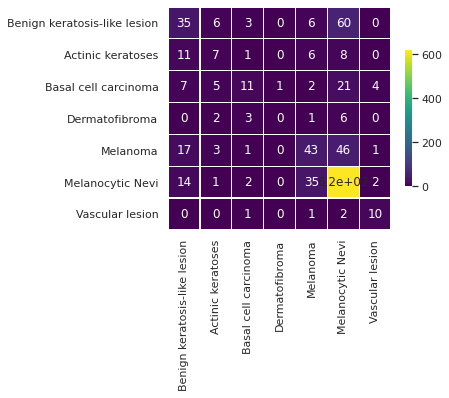

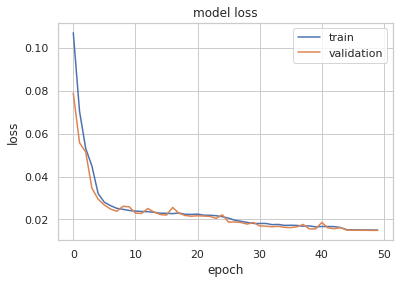

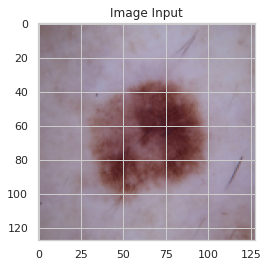

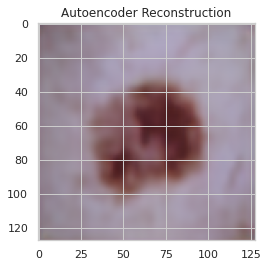

In [ ]:
train_autoencoder(ls_size = 1, plot = True, epochs = 50)

#1.5X COMPRESSION

Epoch 1/50
113/113 [==============================] - 5s 42ms/step - loss: 0.1415 - val_loss: 0.0809
Epoch 2/50
113/113 [==============================] - 5s 41ms/step - loss: 0.0790 - val_loss: 0.0722
Epoch 3/50
113/113 [==============================] - 5s 41ms/step - loss: 0.0660 - val_loss: 0.0517
Epoch 4/50
113/113 [==============================] - 5s 41ms/step - loss: 0.0500 - val_loss: 0.0468
Epoch 5/50
113/113 [==============================] - 5s 41ms/step - loss: 0.0465 - val_loss: 0.0443
Epoch 6/50
113/113 [==============================] - 5s 41ms/step - loss: 0.0439 - val_loss: 0.0407
Epoch 7/50
113/113 [==============================] - 5s 41ms/step - loss: 0.0413 - val_loss: 0.0401
Epoch 8/50
113/113 [==============================] - 5s 41ms/step - loss: 0.0395 - val_loss: 0.0376
Epoch 9/50
113/113 [==============================] - 5s 41ms/step - loss: 0.0380 - val_loss: 0.0367
Epoch 10/50
113/113 [==============================] - 5s 41ms/step - loss: 0.0374 - val_lo

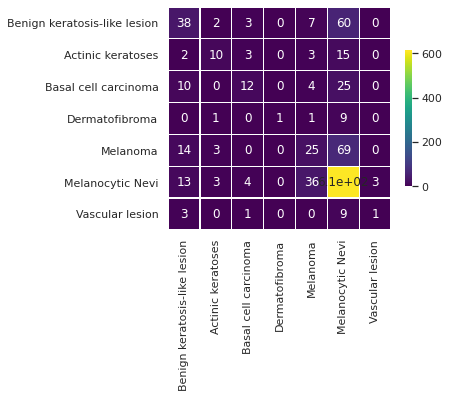

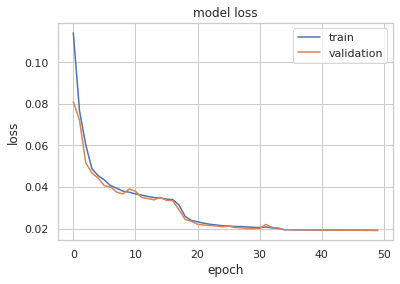

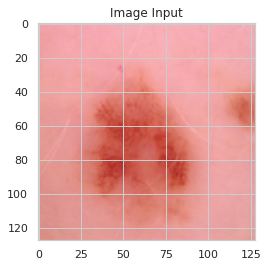

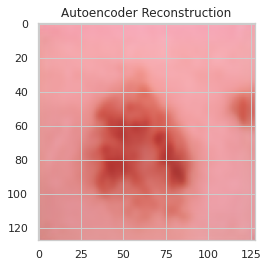

In [ ]:
train_autoencoder(ls_size = 3, plot = True, epochs = 50)

# Joint Optimization

In [ ]:
def inception_trainable():
    base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',pooling='avg', input_shape=(128,128, 3))
    for layer in base_model.layers:
      layer.trainable = True
    return base_model


def gen_joint_model(input_shape,ls_size=2):
    input_layer = Input(input_shape)
    num_classes = 3
    x = input_layer
    # down path
    start_filters = 4
    for i in range(2):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = MaxPool2D()(x)
    # bottleneck
    x = Conv2D(start_filters*(2**ls_size),3, padding='same', activation='relu')(x)
    x = Conv2D(start_filters*(2**ls_size),3, padding='same', activation='relu')(x)
    # up path
    for i in range(2):
        x = UpSampling2D()(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
    x = Conv2D(3, 1, activation='sigmoid')(x)
    inception = inception_trainable()
    x = inception(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02))(x)
    x = Dropout(0.5)(x)
    output = Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

In [ ]:
joint_model = gen_joint_model((128,128,3),ls_size=2)

In [ ]:
joint_model.summary()

Model: "model_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_110 (InputLayer)       [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3542 (Conv2D)         (None, 128, 128, 4)       112       
_________________________________________________________________
conv2d_3543 (Conv2D)         (None, 128, 128, 4)       148       
_________________________________________________________________
max_pooling2d_347 (MaxPoolin (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_3544 (Conv2D)         (None, 64, 64, 8)         296       
_________________________________________________________________
conv2d_3545 (Conv2D)         (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_348 (MaxPoolin (None, 32, 32, 8)         0  

In [ ]:
def train_joint_model(ls_size=2):
  from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
  mcp_save = ModelCheckpoint(f"/content/drive/My Drive/HAM10000/HAM10000_images/full_model_{ls_size}", save_best_only=True, monitor='val_loss', mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
  model = gen_joint_model((128,128,3),ls_size)
  from tensorflow.keras.optimizers import Adam
  optimizer = Adam()
  model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["acc"])
  epochs = 35
  history = model.fit(data_gen.flow(x_train,y_train,batch_size=64),
                              epochs = epochs, validation_data = (x_val,y_val), callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, )
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()
  return model

Epoch 1/35
113/113 [==============================] - 32s 232ms/step - loss: 4.7940 - acc: 0.6293 - val_loss: 2.7145 - val_acc: 0.6694
INFO:tensorflow:Assets written to: /content/drive/My Drive/HAM10000/HAM10000_images/full_model_1/assets
Epoch 2/35
113/113 [==============================] - 25s 224ms/step - loss: 1.5197 - acc: 0.6930 - val_loss: 2.2633 - val_acc: 0.6694
INFO:tensorflow:Assets written to: /content/drive/My Drive/HAM10000/HAM10000_images/full_model_1/assets
Epoch 3/35
113/113 [==============================] - 26s 226ms/step - loss: 1.0909 - acc: 0.6979 - val_loss: 2.0651 - val_acc: 0.6694
INFO:tensorflow:Assets written to: /content/drive/My Drive/HAM10000/HAM10000_images/full_model_1/assets
Epoch 4/35
113/113 [==============================] - 26s 226ms/step - loss: 0.9756 - acc: 0.7113 - val_loss: 8.8267 - val_acc: 0.6694
Epoch 5/35
113/113 [==============================] - 25s 222ms/step - loss: 0.9276 - acc: 0.7187 - val_loss: 1.7580 - val_acc: 0.6694
INFO:tensorfl

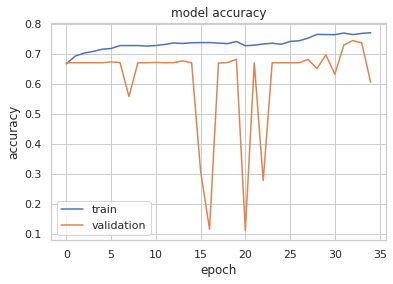

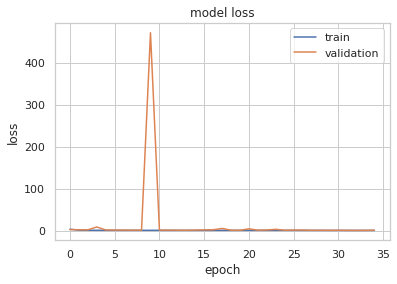

32/32 [==============================] - 1s 24ms/step - loss: 0.5143 - acc: 0.9052
test_accuracy = 0.905190  ;  test_loss = 0.514321


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

Benign keratosis-like lesion       0.36      0.14      0.20       110
           Actinic keratoses       0.22      0.06      0.10        33
        Basal cell carcinoma       0.15      0.98      0.26        51
              Dermatofibroma       0.00      0.00      0.00        12
                    Melanoma       1.00      0.03      0.05       111
            Melanocytic Nevi       0.86      0.77      0.81       671
             Vascular lesion       0.00      0.00      0.00        14

                    accuracy                           0.59      1002
                   macro avg       0.37      0.28      0.20      1002
                weighted avg       0.74      0.59      0.59      1002



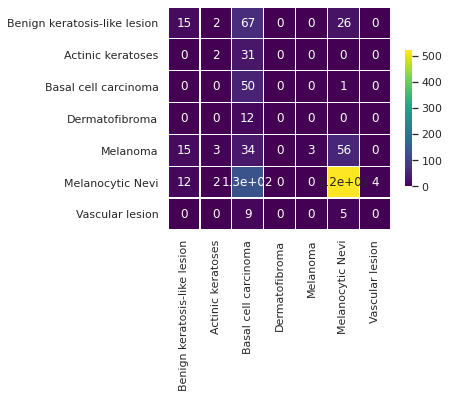

In [ ]:
joint_model = train_joint_model(1)
test_loss, test_acc = trained_model.evaluate(x_test, y_test, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))
metrics(x_test,y_test,joint_model)

Epoch 1/35
113/113 [==============================] - 33s 234ms/step - loss: 4.6485 - acc: 0.6300 - val_loss: 15.2626 - val_acc: 0.6694
INFO:tensorflow:Assets written to: /content/drive/My Drive/HAM10000/HAM10000_images/full_model_2/assets
Epoch 2/35
113/113 [==============================] - 26s 228ms/step - loss: 1.3660 - acc: 0.6996 - val_loss: 13.6790 - val_acc: 0.6694
INFO:tensorflow:Assets written to: /content/drive/My Drive/HAM10000/HAM10000_images/full_model_2/assets
Epoch 3/35
113/113 [==============================] - 26s 227ms/step - loss: 1.0490 - acc: 0.7044 - val_loss: 1.2668 - val_acc: 0.6689
INFO:tensorflow:Assets written to: /content/drive/My Drive/HAM10000/HAM10000_images/full_model_2/assets
Epoch 4/35
113/113 [==============================] - 26s 228ms/step - loss: 0.9198 - acc: 0.7184 - val_loss: 1.1169 - val_acc: 0.6722
INFO:tensorflow:Assets written to: /content/drive/My Drive/HAM10000/HAM10000_images/full_model_2/assets
Epoch 5/35
113/113 [======================

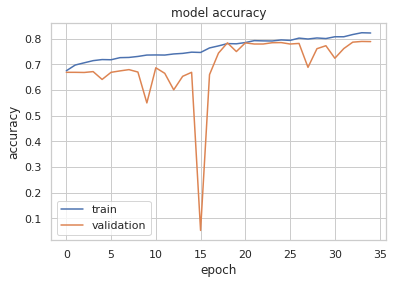

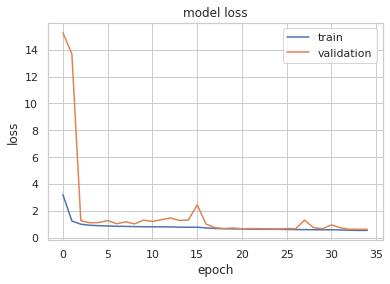

32/32 [==============================] - 1s 24ms/step - loss: 0.5143 - acc: 0.9052
test_accuracy = 0.905190  ;  test_loss = 0.514321


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

Benign keratosis-like lesion       0.50      0.55      0.52       110
           Actinic keratoses       0.47      0.48      0.48        33
        Basal cell carcinoma       0.52      0.65      0.58        51
              Dermatofibroma       0.00      0.00      0.00        12
                    Melanoma       0.59      0.41      0.48       111
            Melanocytic Nevi       0.88      0.92      0.90       671
             Vascular lesion       0.75      0.64      0.69        14

                    accuracy                           0.78      1002
                   macro avg       0.53      0.52      0.52      1002
                weighted avg       0.76      0.78      0.77      1002



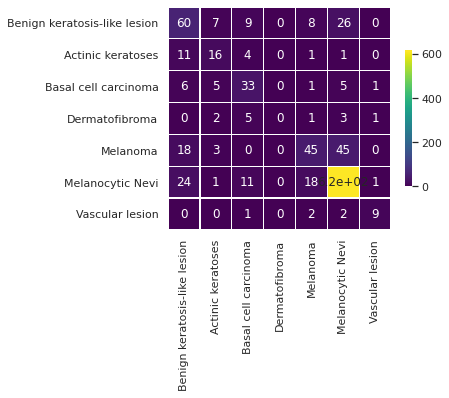

In [ ]:
joint_model = train_joint_model(2)
test_loss, test_acc = trained_model.evaluate(x_test, y_test, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))
metrics(x_test,y_test,joint_model)

Epoch 1/35
113/113 [==============================] - 33s 232ms/step - loss: 4.7790 - acc: 0.6315 - val_loss: 2.2079 - val_acc: 0.6694
INFO:tensorflow:Assets written to: /content/drive/My Drive/HAM10000/HAM10000_images/full_model_3/assets
Epoch 2/35
113/113 [==============================] - 26s 226ms/step - loss: 1.5266 - acc: 0.6909 - val_loss: 1.3651 - val_acc: 0.6500
INFO:tensorflow:Assets written to: /content/drive/My Drive/HAM10000/HAM10000_images/full_model_3/assets
Epoch 3/35
113/113 [==============================] - 26s 227ms/step - loss: 1.1102 - acc: 0.7027 - val_loss: 1.2970 - val_acc: 0.6057
INFO:tensorflow:Assets written to: /content/drive/My Drive/HAM10000/HAM10000_images/full_model_3/assets
Epoch 4/35
113/113 [==============================] - 26s 227ms/step - loss: 0.9627 - acc: 0.7119 - val_loss: 1.0218 - val_acc: 0.6972
INFO:tensorflow:Assets written to: /content/drive/My Drive/HAM10000/HAM10000_images/full_model_3/assets
Epoch 5/35
113/113 [========================

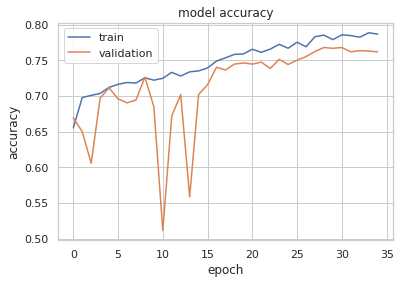

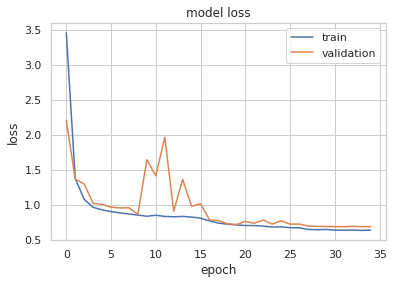

32/32 [==============================] - 1s 24ms/step - loss: 0.4875 - acc: 0.9212
test_accuracy = 0.921158  ;  test_loss = 0.487475


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

Benign keratosis-like lesion       0.61      0.46      0.53       110
           Actinic keratoses       0.43      0.30      0.36        33
        Basal cell carcinoma       0.47      0.67      0.55        51
              Dermatofibroma       0.00      0.00      0.00        12
                    Melanoma       0.55      0.39      0.46       111
            Melanocytic Nevi       0.86      0.94      0.90       671
             Vascular lesion       0.38      0.21      0.27        14

                    accuracy                           0.77      1002
                   macro avg       0.47      0.43      0.44      1002
                weighted avg       0.75      0.77      0.75      1002



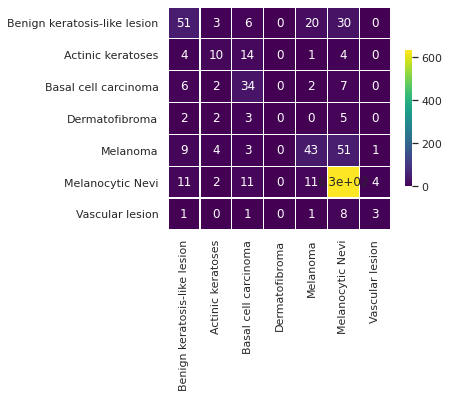

In [ ]:
joint_model = train_joint_model(3)
test_loss, test_acc = trained_model.evaluate(x_test, y_test, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))
metrics(x_test,y_test,joint_model)

# IMAGE EXAMPLES

In [ ]:
data_labels = ['Benign keratosis-like lesion', 'Actinic keratoses', 'Basal cell carcinoma', 'Dermatofibroma', 'Melanoma', 'Melanocytic Nevi', 'Vascular lesion']
plt.rcParams["axes.grid"] = False
im_examples = []
im_indeces = []
for i in range(0,7):
  for j,im in enumerate(y_test):
    if i == np.argmax(im):
      im_examples.append(x_test[j])
      im_indeces.append(j)
      break

def plot_ims(images):
  plt.figure(figsize = (20,10))
  plt.title("Original Images")
  for i, image in enumerate(images):
    plt.subplot(1,7,i+1)
    plt.imshow(image)
    plt.title(data_labels[i])
    plt.xticks([])
    plt.yticks([])
  

In [ ]:
autoencoder_1 = tf.keras.models.load_model("/content/drive/My Drive/HAM10000/HAM10000_images/autoencoder_1")
autoencoder_2 = tf.keras.models.load_model("/content/drive/My Drive/HAM10000/HAM10000_images/autoencoder_2")
autoencoder_3 = tf.keras.models.load_model("/content/drive/My Drive/HAM10000/HAM10000_images/autoencoder_3")

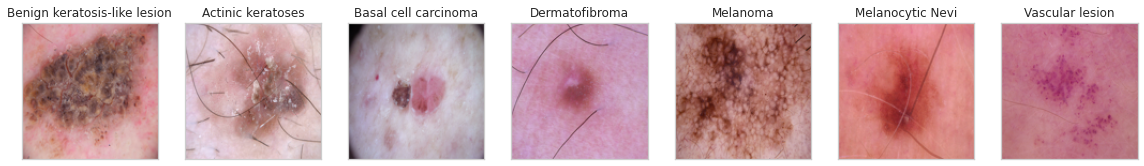

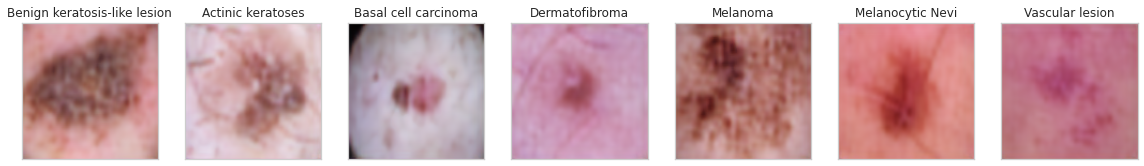

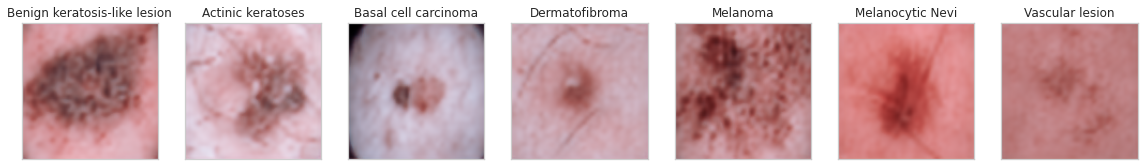

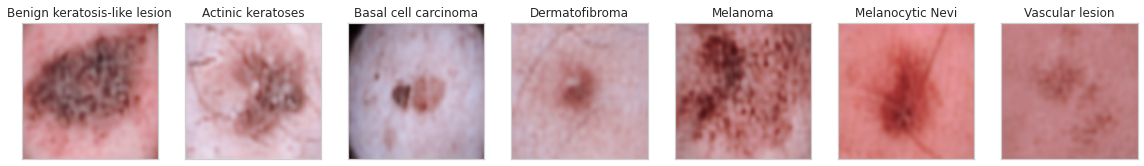

In [ ]:
plot_ims(im_examples)
plot_ims(autoencoder_1.predict(x_test)[im_indeces])
plot_ims(autoencoder_2.predict(x_test)[im_indeces])
plot_ims(autoencoder_3.predict(x_test)[im_indeces])

32/32 [==============================] - 1s 25ms/step - loss: 1.1768 - acc: 0.7385
test_accuracy = 0.738523  ;  test_loss = 1.176805
              precision    recall  f1-score   support

         BKL       0.43      0.33      0.37       110
          AK       0.47      0.27      0.35        33
         BCC       0.73      0.37      0.49        51
          DF       0.00      0.00      0.00        12
         MEL       0.51      0.38      0.44       111
         NEV       0.81      0.93      0.87       671
         VAS       0.47      0.50      0.48        14

    accuracy                           0.74      1002
   macro avg       0.49      0.40      0.43      1002
weighted avg       0.71      0.74      0.71      1002

32/32 [==============================] - 1s 24ms/step - loss: 1.2854 - acc: 0.7315
test_accuracy = 0.731537  ;  test_loss = 1.285435
              precision    recall  f1-score   support

         BKL       0.42      0.34      0.37       110
          AK       0.48     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         BKL       0.41      0.32      0.36       110
          AK       0.56      0.15      0.24        33
         BCC       0.65      0.29      0.41        51
          DF       0.00      0.00      0.00        12
         MEL       0.42      0.33      0.37       111
         NEV       0.79      0.93      0.86       671
         VAS       0.75      0.21      0.33        14

    accuracy                           0.72      1002
   macro avg       0.51      0.32      0.37      1002
weighted avg       0.68      0.72      0.69      1002



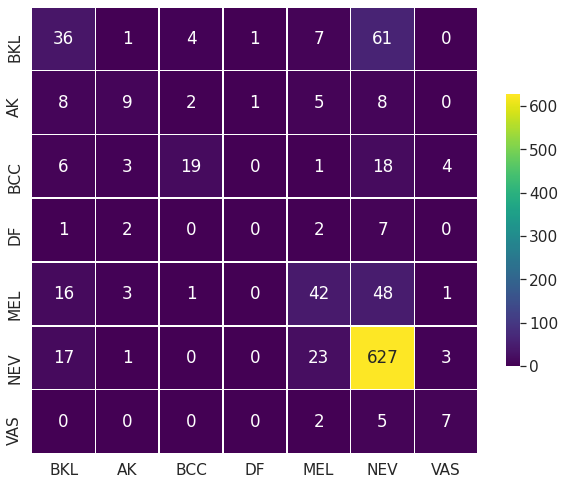

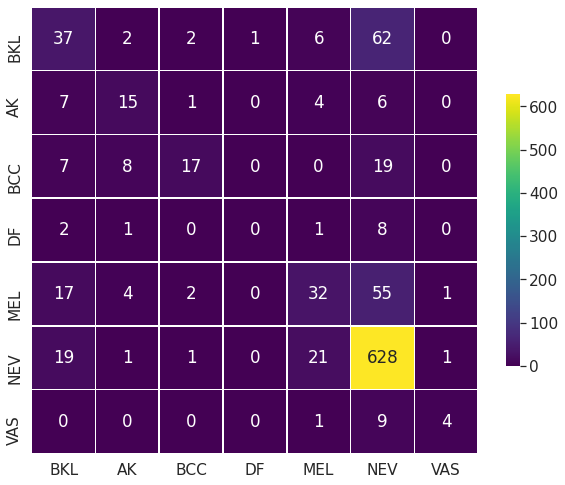

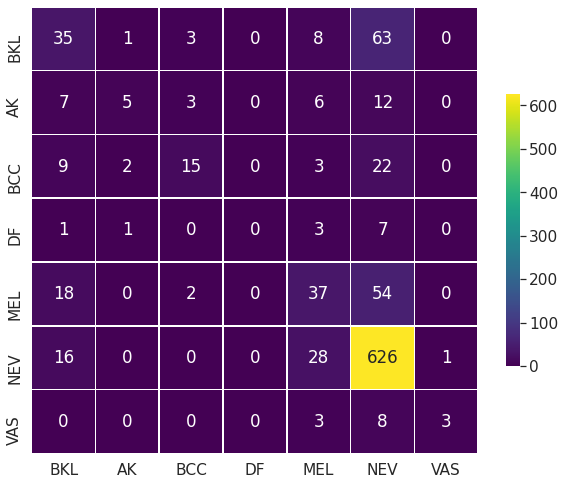

In [ ]:
eval_autoencoder_performance(trained_model, autoencoder_1)
eval_autoencoder_performance(trained_model, autoencoder_2)
eval_autoencoder_performance(trained_model, autoencoder_3)

In [ ]:
fullmodel_1 = tf.keras.models.load_model("/content/drive/My Drive/HAM10000/HAM10000_images/full_model_1")
fullmodel_2 = tf.keras.models.load_model("/content/drive/My Drive/HAM10000/HAM10000_images/full_model_2")
fullmodel_3 = tf.keras.models.load_model("/content/drive/My Drive/HAM10000/HAM10000_images/full_model_3")

In [ ]:
def extract_autoencode(model_source,model_target):
  for l_tg,l_sr in zip(model_target.layers,model_source.layers):
        wk0=l_sr.get_weights()
        l_tg.set_weights(wk0)
        if l_sr.name=="inception_v3":
            break

fullmodel_1_autoencoder = create_autoencoder((128,128,3),1)
extract_autoencode(fullmodel_1,fullmodel_1_autoencoder)
fullmodel_2_autoencoder = create_autoencoder((128,128,3),2)
extract_autoencode(fullmodel_2,fullmodel_2_autoencoder)
fullmodel_3_autoencoder = create_autoencoder((128,128,3),3)
extract_autoencode(fullmodel_3,fullmodel_3_autoencoder)

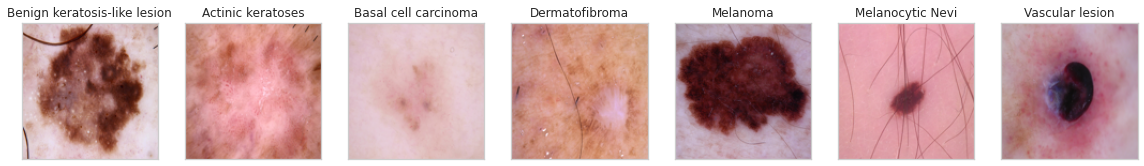

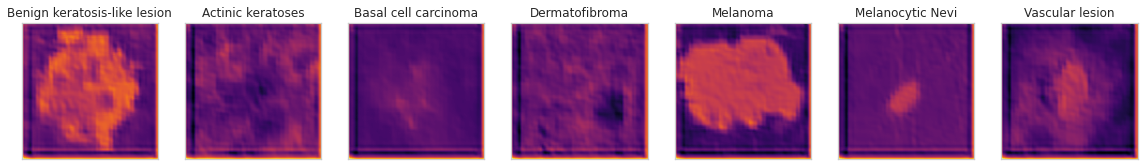

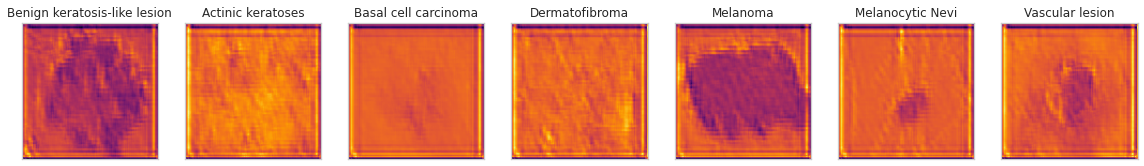

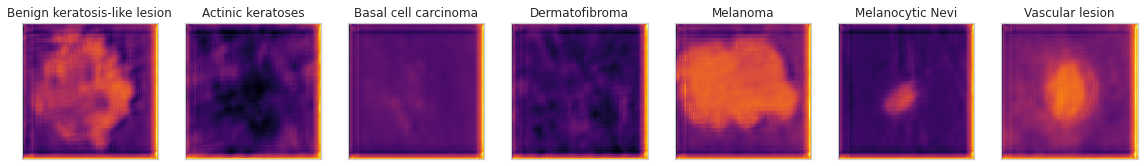

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def plot_ims_map(images):
  plt.figure(figsize = (20,10))
  plt.title("Original Images")
  for i, image in enumerate(images):
    image = rgb2gray(image)
    plt.subplot(1,7,i+1)
    plt.imshow(image,cmap="inferno")
    plt.title(data_labels[i])
    plt.xticks([])
    plt.yticks([])


plot_ims(im_examples)
plot_ims_map(fullmodel_1_autoencoder.predict(x_test)[im_indeces])
plot_ims_map(fullmodel_2_autoencoder.predict(x_test)[im_indeces])
plot_ims_map(fullmodel_3_autoencoder.predict(x_test)[im_indeces])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         BKL       0.78      0.26      0.39       110
          AK       0.57      0.24      0.34        33
         BCC       0.44      0.78      0.57        51
          DF       0.00      0.00      0.00        12
         MEL       0.52      0.32      0.39       111
         NEV       0.81      0.96      0.88       671
         VAS       1.00      0.07      0.13        14

    accuracy                           0.76      1002
   macro avg       0.59      0.38      0.39      1002
weighted avg       0.74      0.76      0.72      1002

              precision    recall  f1-score   support

         BKL       0.60      0.60      0.60       110
          AK       0.67      0.48      0.56        33
         BCC       0.63      0.78      0.70        51
          DF       0.00      0.00      0.00        12
         MEL       0.56      0.48      0.52       111
         NEV       0.91      0.94      0.92       671
         VAS       1.00 

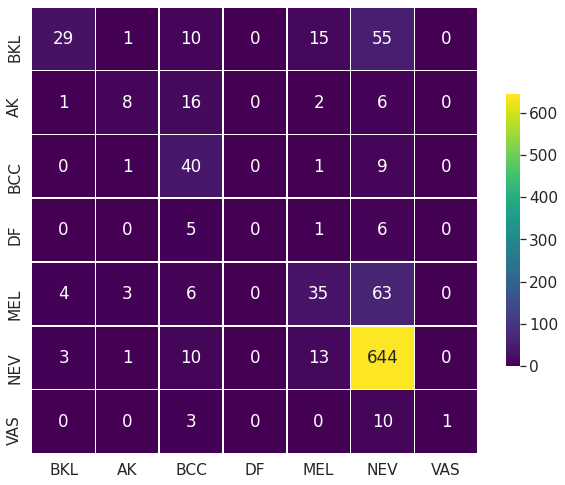

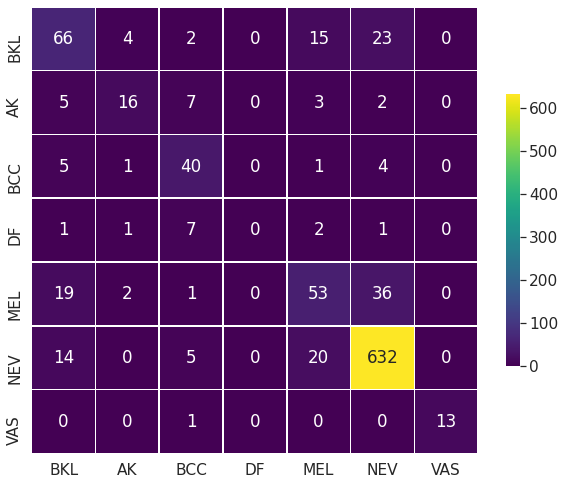

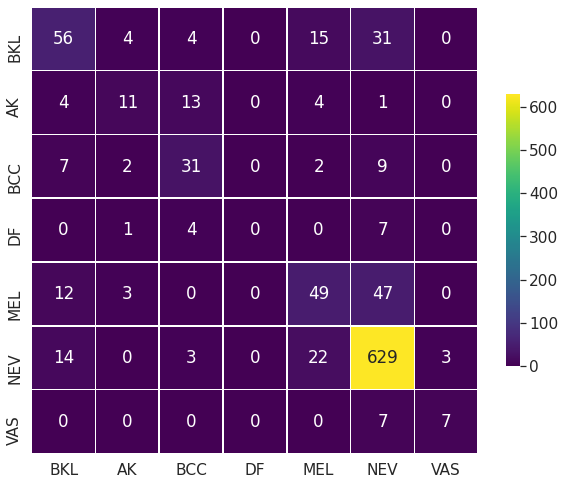

In [ ]:
metrics(x_test,y_test,fullmodel_1)
metrics(x_test,y_test,fullmodel_2)
metrics(x_test,y_test,fullmodel_3)

In [ ]:
test_loss, test_acc = fullmodel_1.evaluate(x_test, y_test, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))
test_loss, test_acc = fullmodel_2.evaluate(x_test, y_test, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))
test_loss, test_acc = fullmodel_3.evaluate(x_test, y_test, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))

32/32 [==============================] - 2s 28ms/step - loss: 0.7199 - acc: 0.7555
test_accuracy = 0.755489  ;  test_loss = 0.719885
32/32 [==============================] - 2s 28ms/step - loss: 0.5478 - acc: 0.8184
test_accuracy = 0.818363  ;  test_loss = 0.547833
32/32 [==============================] - 2s 29ms/step - loss: 0.6099 - acc: 0.7814
test_accuracy = 0.781437  ;  test_loss = 0.609893
